## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
chess_images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in chess_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

### Than, I'll apply a distortion correction to raw images.

In [2]:
# Function for undistortion of any image
def undistort(img, objpoints, imgpoints):   
    img_size = (img.shape[1], img.shape[0])
    # take calibration constants
    ret, mtx, dist, rvecs, tcevs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    # use the camera matrix (mtx) and distortion coefficients (dist) for undistortion
    undist=cv2.undistort(img, mtx, dist, None, mtx)    
    return undist   

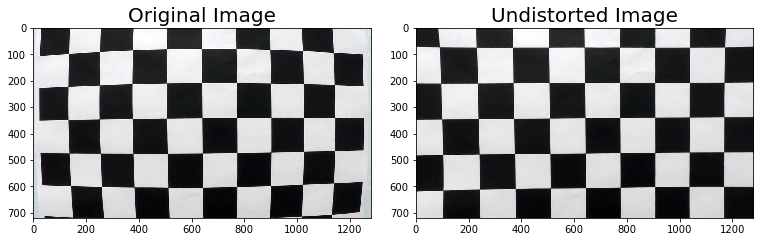

In [3]:
%matplotlib inline
# visualize undistort of Chessboard image
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [4]:
# save all undistorted images in output_images directory
img_dir = 'test_images/'
undist_dir = 'output_images/undistorted/'
raw_images = glob.glob(img_dir+'*.jpg')

for image in raw_images:
    img=undistort(cv2.imread(image), objpoints, imgpoints)
    cv2.imwrite(undist_dir+image[12:], img)
    

Text(0.5, 1.0, 'Undistorted Image')

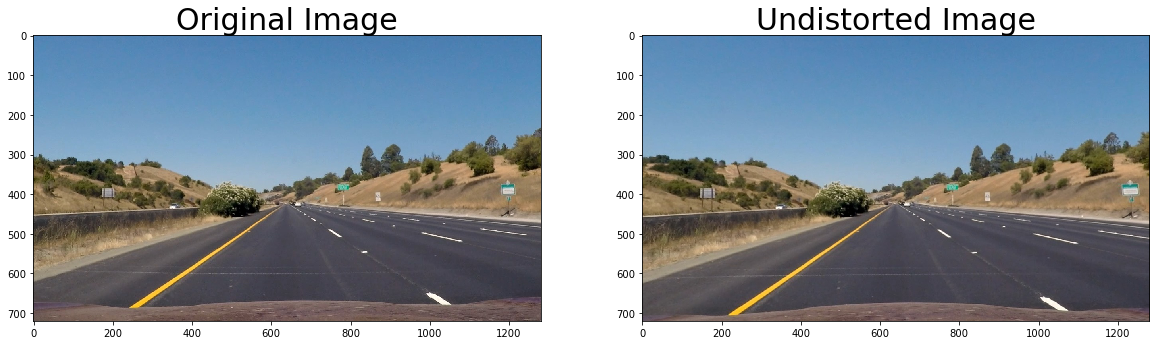

In [5]:
import matplotlib.image as mpimg

# show an example for an undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(mpimg.imread(img_dir+"straight_lines1.jpg"))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(mpimg.imread(undist_dir+"straight_lines1.jpg"))
ax2.set_title('Undistorted Image', fontsize=30)

### Now, I'll use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
# Include threshold mask functions from the threshold file
from thresholds import *

# chose the best combination of masks
def thmask(img):
    absolute_sobel_x = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    color_hls_S = hls_select(img, channel='S', thresh=(90, 255))    
    combined_binary = np.zeros_like(absolute_sobel_x)
    combined_binary[(color_hls_S == 1) | (absolute_sobel_x == 1)] = 1
    return combined_binary

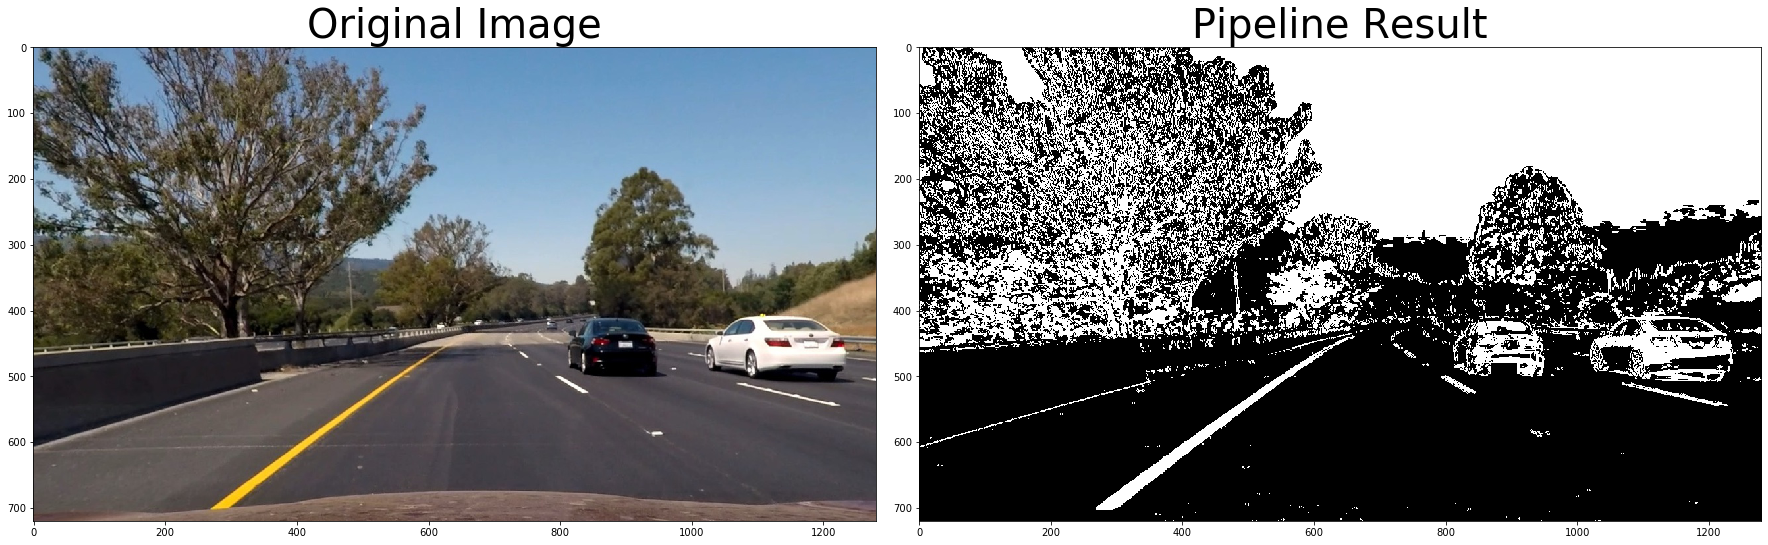

In [7]:
img = mpimg.imread(undist_dir+"test6.jpg")
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(thmask(img), cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
# save all threshold masked images in output_images directory
img_dir = 'output_images/undistorted/'
thmask_dir = 'output_images/thresholded/'
raw_images = glob.glob(img_dir+'*.jpg')

for image in raw_images:
    img = thmask(cv2.imread(image))
    img = np.dstack(( img, img, img))*255 
    cv2.imwrite(thmask_dir+image[26:], img)    

### Than, I'll apply a perspective transform to rectify binary image ("birds-eye view")

In [43]:
# corners for source
src = np.float32([[[679, 447],        # top right (x,y)
                   [1090,700],        # bottom right (x,y)
                   [225, 700],        # bottom left (x,y)
                   [600, 447]]])      # top left (x,y)
# corners for destination
dst = np.float32([[[850, 0],          # top right (x,y)
                   [850, 720],        # bottom right (x,y)
                   [250, 720],        # bottom left (x,y)
                   [250, 0]]])        # top left (x,y)

In [44]:
# make a function for Perspective Transform
def p_transfer(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # return warped image
    #src = np.float32([[[679, 447], [1002,700], [300, 700],[600, 447]]])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped    

In [45]:
# save all threshold masked images in output_images directory
src_dir = 'output_images/undistorted/'
dst_dir = 'output_images/transformed/'
raw_images = glob.glob(src_dir+'*.jpg')

for image in raw_images:
    img = p_transfer(cv2.imread(image), src,dst)
    cv2.imwrite(dst_dir+image[26:], img)   

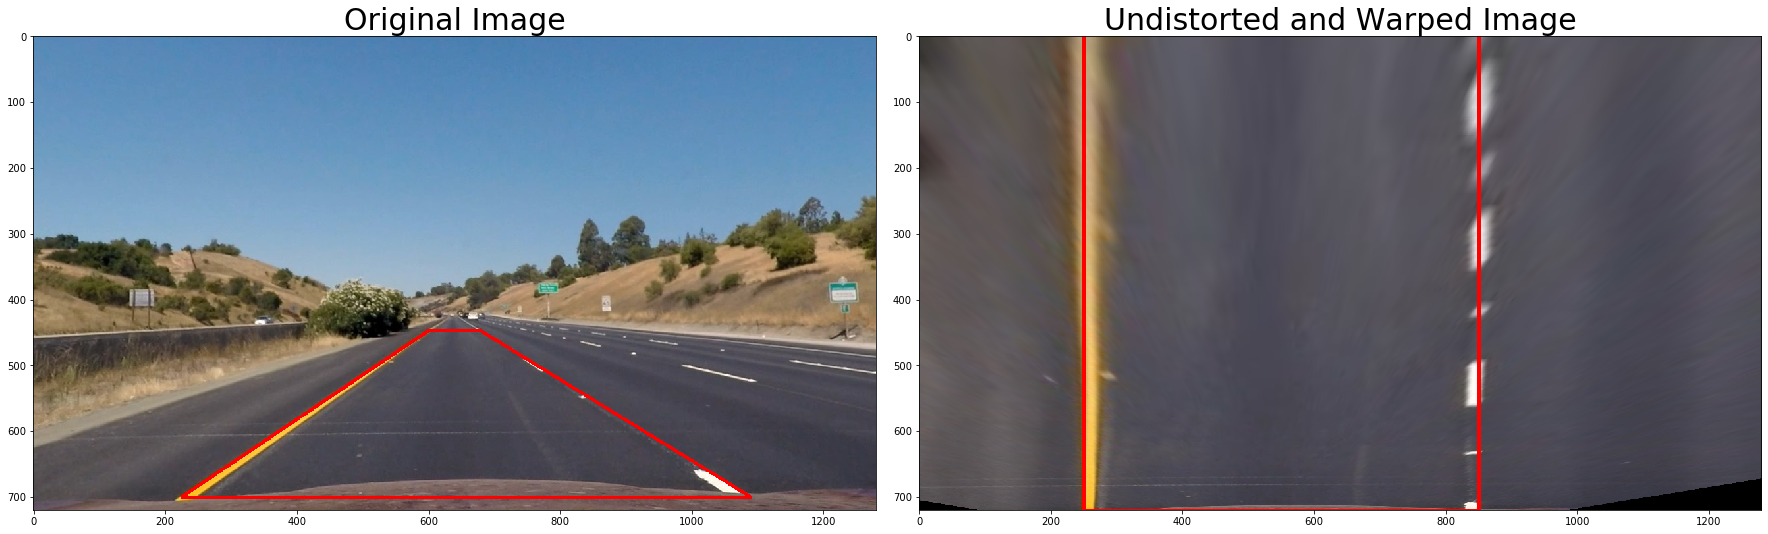

In [48]:
# show an example for a transformed pictures   
img = mpimg.imread(undist_dir+"straight_lines1.jpg")
warped = p_transfer(img, src, dst)
# Show transfer boundaries from the source image to the destination image
cv2.polylines(warped, np.int32(dst),False,(255,0,0),3)
cv2.polylines(img, np.int32(src),True,(255,0,0),3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Later, I'll detect lane pixels and fit to find the lane boundary.